## Automated Detection of Layers from Pictures

This cell loads one image at a time.

Non-Stacked


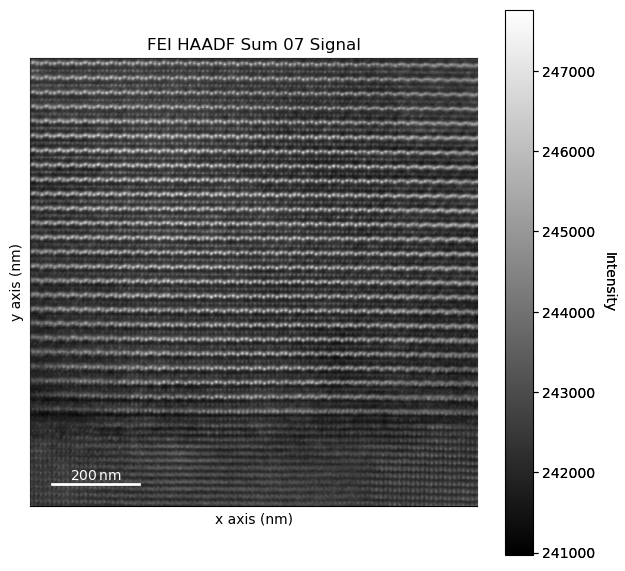

In [1]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import atomap.api as am
import sys
sys.path.append('..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
# s_load = hs.load('../data/images/Jaume LFO/FEI HAADF Sum 06.dm3')
# s_load = hs.load('../data/images/Jaume LFO/HAADF_01.dm3')
s_load = hs.load('../data/images/Jaume LFO/FEI HAADF Sum 07.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

In [17]:
import scipy.signal
import numpy as np

# left_bound = 500 # TUNE THIS
# right_bound = 1700 # TUNE THIS
# start_pixel = 280 # TUNE THIS
# end_pixel = 1400 # TUNE THIS

# left_bound = 200 # TUNE THIS
# right_bound = 900 # TUNE THIS
# start_pixel = 0 # TUNE THIS
# end_pixel = 700 # TUNE THIS

left_bound = 300 # TUNE THIS
right_bound = 800 # TUNE THIS
start_pixel = 0 # TUNE THIS
end_pixel = 500 # TUNE THIS

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)
crop.get_horizontal_peaks(get_plot=False)
crop.get_vertical_peaks(get_plot=False)

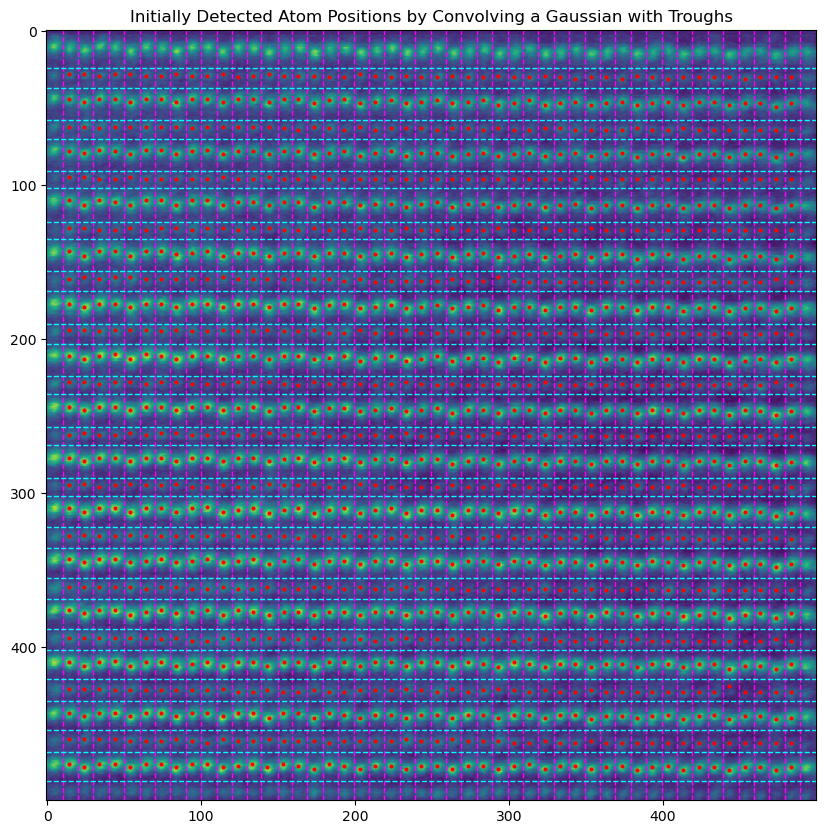

In [18]:
crop.build_grid_dict()

crop.get_atom_positions(get_plot=True)
# crop.refine_atom_positions()
# crop.plot_positions()

# crop.voronoi()
crop.get_atom_types()

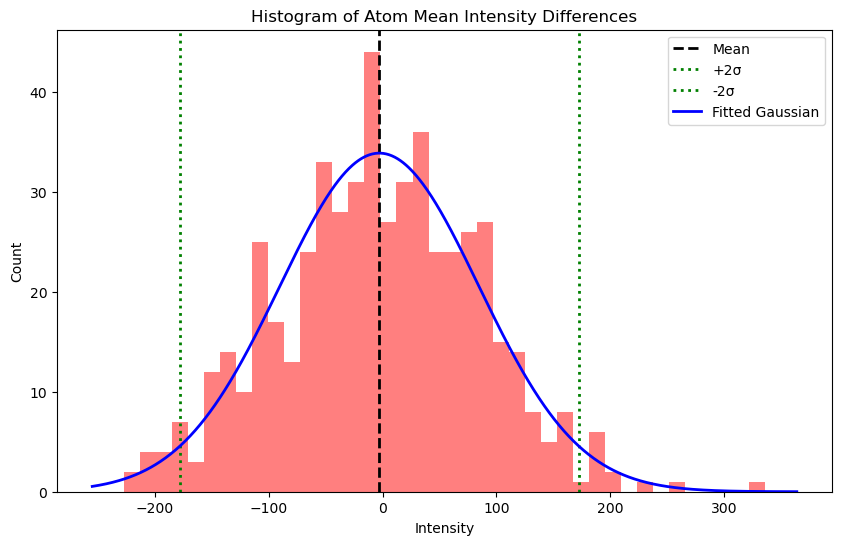

In [23]:
crop.get_nn_intensities_same(horizonal_radius = 2, vertical_radius=2)
# crop.get_nn_intensities_all(horizonal_radius = 2, vertical_radius=2)

outlier_bar = 2
# crop.get_nn_displacements()
crop.get_intensity_z_score_outliers(outlier_bar=outlier_bar, atom_type='Lu', atom_selection='same')
crop.plot_intensity_outliers_z_score_histogram(outlier_bar=outlier_bar, fit_gaussian=True)
# crop.plot_intensity_outliers_z_score_overlay(outlier_bar=outlier_bar)

In [24]:
import scipy.stats as stats
mu, sigma = stats.norm.fit(crop.intensity_from_vincinity_mean)

In [25]:
import numpy as np
from scipy.stats import norm, chisquare

data = np.asarray(crop.intensity_from_vincinity_mean)

# 1) Histogram with counts (not density)
counts, edges = np.histogram(data, bins=40)

# 2) Expected counts from fitted Gaussian
expected = len(data) * (norm.cdf(edges[1:], mu, sigma) - norm.cdf(edges[:-1], mu, sigma))

# 3) Drop bins with tiny expectation to keep test valid
mask = expected > 1  # or > 5 if you want to be stricter
counts_chi   = counts[mask]
expected_chi = expected[mask]

# IMPORTANT: 4) Renormalize expected to match observed total after masking
scale = counts_chi.sum() / expected_chi.sum()
expected_chi = expected_chi * scale

# 5) Chi-square test; subtract 2 df for estimated (mu, sigma)
chi2_stat, p_val = chisquare(f_obs=counts_chi, f_exp=expected_chi, ddof=2)

print(f"Chi-square = {chi2_stat:.3f}, p = {p_val:.4f}")
print(f"bins used = {counts_chi.size}")


Chi-square = 36.980, p = 0.1467
bins used = 32


/var/folders/_w/v56drf556mx31xc17rw2g1yh0000gn/T/ipykernel_98413/2662411540.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


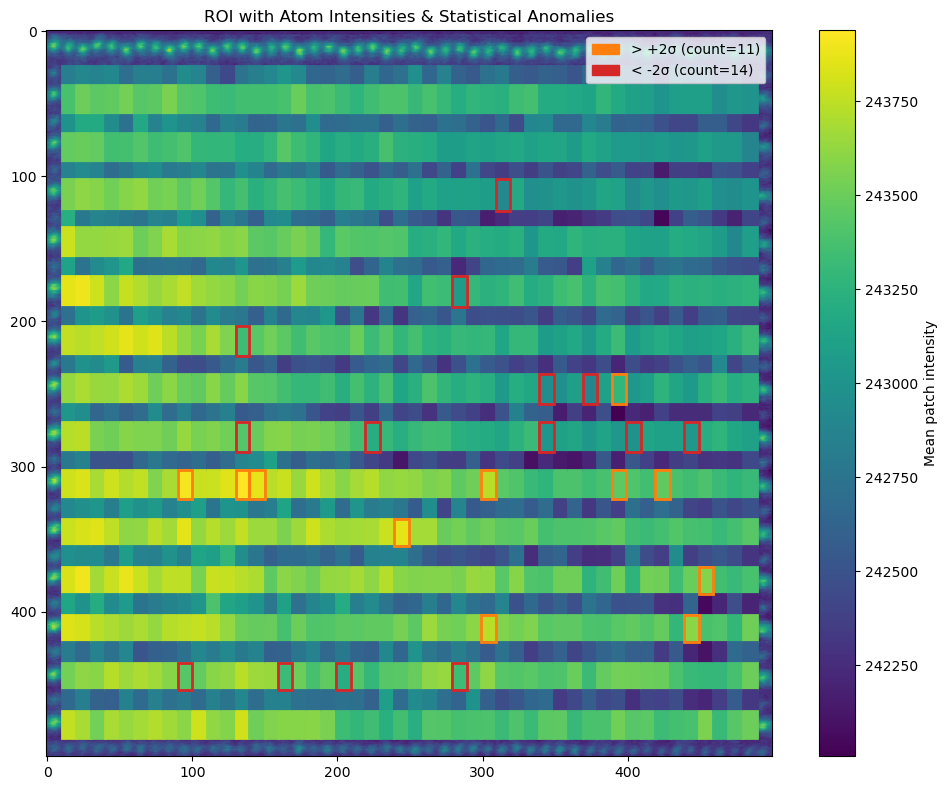

In [26]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.close()

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(crop.roi)

mean_intensities = [patch.mean_intensity for patch in crop.grid.values()]
norm = mcolors.Normalize(vmin=min(mean_intensities), vmax=max(mean_intensities))
# sum_intensity = [patch.sum_intensity for patch in crop.grid.values()]
# norm = mcolors.Normalize(vmin=min(sum_intensity), vmax=max(sum_intensity))
cmap = cm.get_cmap('viridis')

above_color='#FF7F0E'
below_color='#D62728' 

def _get_edges(patch):
    col_edges = patch.roi_col_edges
    row_edges = patch.roi_row_edges
    x0, x1 = float(col_edges[0]), float(col_edges[1])
    y0, y1 = float(row_edges[0]), float(row_edges[1])
    return x0, x1, y0, y1

def _draw_box(patch, color, fill, z):
    edges = _get_edges(patch)
    if edges is None:
        return
    x0, x1, y0, y1 = edges
    wr = x1 - x0
    hr = y1 - y0

    # Draw box (semi-transparent fill to see the atom)
    rect = Rectangle((x0, y0), wr, hr, edgecolor=color, fill=fill, linewidth=2, facecolor=color, zorder=z)
    ax.add_patch(rect)

for patch in crop.grid.values():
    _draw_box(patch, color=cmap(norm(patch.mean_intensity)), fill=True, z=1)
    # _draw_box(patch, color=cmap(norm(patch.sum_intensity)), fill=True, z=1)

# Draw ABOVE
for (i, j) in crop.intensity_from_vincinity_outliers_above:
    patch = crop.grid[i, j]
    _draw_box(patch, color=above_color, fill=False, z=3)

# Draw BELOW
for (i, j) in crop.intensity_from_vincinity_outliers_below:
    patch = crop.grid[i, j]
    _draw_box(patch, color=below_color, fill=False, z=3)

count_above = len(crop.intensity_from_vincinity_outliers_above)
count_below = len(crop.intensity_from_vincinity_outliers_below)

above_proxy  = Rectangle((0, 0), 1, 1, edgecolor=above_color,  facecolor=above_color)
below_proxy = Rectangle((0, 0), 1, 1, edgecolor=below_color, facecolor=below_color)
ax.legend(
    [above_proxy, below_proxy],
    [f"> +{outlier_bar}σ (count={count_above})",
     f"< -{outlier_bar}σ (count={count_below})"],
    loc="best"
)

ax.set_title('ROI with Atom Intensities & Statistical Anomalies')
# ax.set_title('ROI with Atom Intensities')

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(mean_intensities)
# sm.set_array(sum_intensity)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Mean patch intensity")

plt.tight_layout()
plt.show()

In [27]:
isof_dict = crop.get_intensity_outliers_isoforest(atom_type='Lu')

/Users/wujn/Documents/GitHub/LuFeO3Detect/notebooks/../util/crop_classification.py:203: RuntimeWarning: All-NaN slice encountered
  feat_medians = np.nanmedian(X, axis=0)


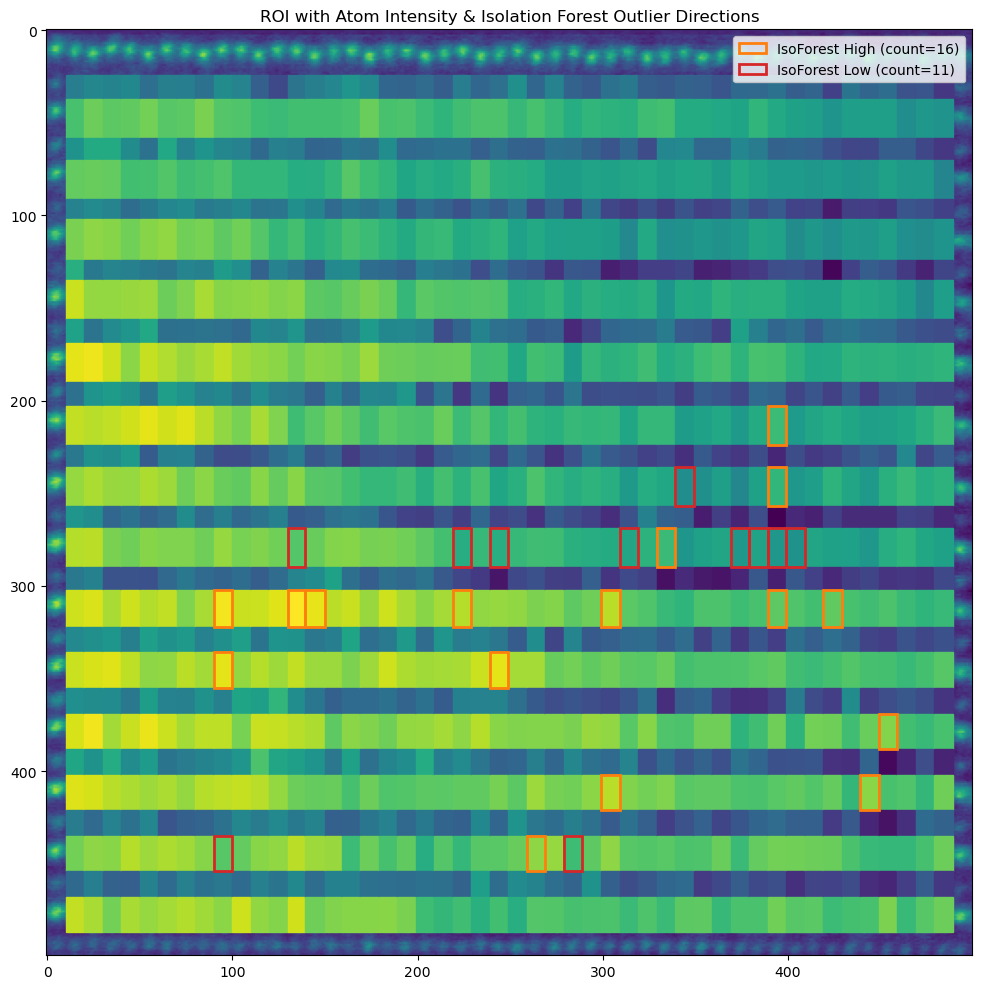

In [28]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.close()
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(crop.roi)

# Draw intensity grid (filled rectangles)
for patch in crop.grid.values():
    color = cmap(norm(patch.mean_intensity))
    x0, x1 = patch.roi_col_edges
    y0, y1 = patch.roi_row_edges
    rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=color, facecolor=color, fill=True, zorder=1)
    ax.add_patch(rect)

# Define colors for directions
high_color='#FF7F0E'
low_color='#D62728' 

# Overlay Isolation Forest outliers by direction
for patch in crop.grid.values():
    x0, x1 = patch.roi_col_edges
    y0, y1 = patch.roi_row_edges
    if hasattr(patch, 'iforest_direction'):
        if patch.iforest_direction == 'high':
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=high_color, fill=False, linewidth=2, zorder=3)
            ax.add_patch(rect)
        elif patch.iforest_direction == 'low':
            rect = Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor=low_color, fill=False, linewidth=2, zorder=3)
            ax.add_patch(rect)

count_above = len(crop.iforest_outliers_high)
count_below = len(crop.iforest_outliers_low)

high_proxy = Rectangle((0, 0), 1, 1, edgecolor=high_color, facecolor='none', linewidth=2)
low_proxy = Rectangle((0, 0), 1, 1, edgecolor=low_color, facecolor='none', linewidth=2)
ax.legend(
    [high_proxy, low_proxy],
    [f"IsoForest High (count={count_above})",
     f"IsoForest Low (count={count_below})"],
    loc="best"
)

ax.set_title('ROI with Atom Intensity & Isolation Forest Outlier Directions')
plt.tight_layout()
plt.show()

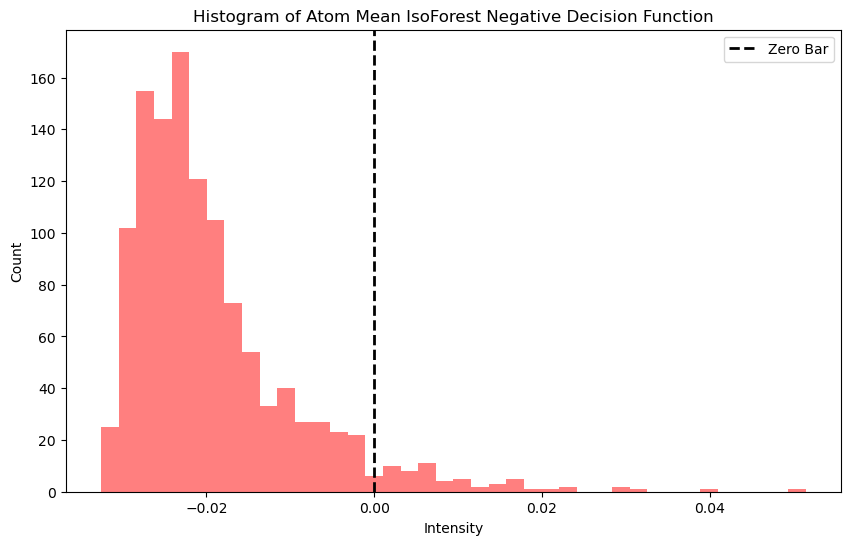

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(crop.iforest_anomaly_score, bins=40, color='red', alpha=0.5)
mean_val = np.mean(crop.iforest_anomaly_score)
std_val = np.std(crop.iforest_anomaly_score)

plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Bar')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Histogram of Atom Mean IsoForest Negative Decision Function')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import cohen_kappa_score

isof_high = isof_dict['outliers_high']
isof_low = isof_dict['outliers_low']
z_high = crop.intensity_from_vincinity_outliers_above
z_low = crop.intensity_from_vincinity_outliers_below

A_high, A_low = set(isof_high), set(isof_low)
B_high, B_low = set(z_high),   set(z_low)
all_idx = set(crop.grid.keys())

def labels_from_sets(H, L, universe):
    # optional: guard against the same index being both high and low
    assert len(H & L) == 0, "Some indices are marked both high and low."
    y = {}
    for idx in universe:
        y[idx] = 1 if idx in H else (-1 if idx in L else 0)
    order = sorted(universe)
    return order, np.array([y[i] for i in order], dtype=int)

order, yA = labels_from_sets(A_high, A_low, all_idx)
_,     yB = labels_from_sets(B_high, B_low, all_idx)

kappa = cohen_kappa_score(yA, yB, labels=[-1, 0, 1])
print(f"Cohen's kappa = {kappa:.3f}")


Cohen's kappa = 0.690


In [12]:
mask_outlier = (yA != 0) | (yB != 0)
mask_agree_direction = (yA == yB) & mask_outlier

total = np.sum(mask_outlier)
agreements = np.sum(mask_agree_direction)
prop_agreement = agreements / total if total > 0 else float('nan')

print(f"Direction agreement (outlier-only) = {prop_agreement:.3f} ({agreements}/{total})")

Direction agreement (outlier-only) = 0.532 (41/77)
